# Deep Q-Network (DQN) - CartPole-v1

My name is **Nikos**, and this project along with others in this folder mark a significant milestone in my journey to becoming an AI Engineer. I’m passionate about artificial intelligence and machine learning, and this project serves as the first step in that path. Through it, I aim to not only understand how neural networks work but also demonstrate the practical applications of AI in real-world problems.

This project implements a **Deep Q-Network (DQN)** using **PyTorch** to solve the **CartPole-v1** environment from OpenAI Gym. The goal is to balance a pole on a cart for as long as possible.

The DQN agent is trained using reinforcement learning techniques, where it learns to select the best action by interacting with the environment. This project demonstrates how to apply DQN with target and local networks, experience replay, and epsilon-greedy exploration strategies.

---

**IMPORT NECESSARY LIBRARIES**

In this section, we import the required libraries, such as **Gym** for the environment, **PyTorch** for building the neural network, and other utilities like **numpy**, **random**, and **matplotlib** for data handling and visualization.

---

**SETTING RANDOM SEEDS**

Setting random seeds for reproducibility ensures that the results can be replicated under the same conditions.


In [3]:
# Import necessary libraries
import gym
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
from IPython.display import HTML
import matplotlib.animation as animation
import torch
import torch.nn as nn
import torch.optim as optim

# Set random seeds for reproducibility
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

---

**DEFINE THE Q-NETWORK**

The **Q-Network** is a simple fully connected neural network with two hidden layers (each with 64 units). This network maps input states to the corresponding action values.

Key points:
- The input layer has the state size (4 for CartPole).
- The output layer has the action size (2 possible actions in CartPole: left or right).
- Two hidden layers with ReLU activation.

---

In [4]:
# Define the Q-Network using PyTorch
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed=0):
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        # Define the network layers
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.out = nn.Linear(64, action_size)
    
    def forward(self, state):
        # Forward pass through the network
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return self.out(x)

---

**IMPLEMENT THE DQN AGENT**

In this section, we define the **DQNAgent** class. The agent interacts with the environment by:
1. Selecting actions based on the current policy (using epsilon-greedy).
2. Storing experiences in the replay buffer.
3. Learning from sampled experiences to update the Q-network.

Key components:
- **Q-Network**: Two Q-networks (local and target) for stable learning.
- **Replay Buffer**: Stores experience tuples for training.
- **Soft Update**: Updates the target network parameters with the local network parameters using a small factor **tau**.

------

**IMPLEMENT THE DQN AGENT**

In this section, we define the **DQNAgent** class. The agent interacts with the environment by:
1. Selecting actions based on the current policy (using epsilon-greedy).
2. Storing experiences in the replay buffer.
3. Learning from sampled experiences to update the Q-network.

Key components:
- **Q-Network**: Two Q-networks (local and target) for stable learning.
- **Replay Buffer**: Stores experience tuples for training.
- **Soft Update**: Updates the target network parameters with the local network parameters using a small factor **tau**.

---

**ACT METHOD (EPSILON-GREEDY POLICY)**

The agent selects actions using an epsilon-greedy policy:
- With probability epsilon, it selects a random action (exploration).
- With probability 1-epsilon, it selects the action with the highest Q-value (exploitation).

---

**LEARN METHOD**

The **learn** function updates the agent's Q-values based on a mini-batch of experiences sampled from the replay buffer. It computes the expected Q-values and the target Q-values, calculates the loss, and performs a gradient descent step to minimize the loss.

---

**SOFT UPDATE OF TARGET NETWORK**

We apply soft updates to the target network to slowly align it with the local network, ensuring smoother training and preventing instability. The formula used is **θ_target = τ * θ_local + (1 - τ) * θ_target**.

---

In [ ]:
# Define the DQN Agent
class DQNAgent:
    def __init__(self, state_size, action_size, seed=0):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        
        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed)
        self.qnetwork_target = QNetwork(state_size, action_size, seed)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=5e-4)
        
        # Replay memory
        self.memory = deque(maxlen=10000)  # Buffer size
        self.batch_size = 64               # Mini-batch size
        
        # Hyperparameters
        self.gamma = 0.99        # Discount factor
        self.tau = 1e-3          # Soft update parameter
        self.update_every = 4    # How often to update the network
        self.t_step = 0          # Time step counter
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.append((state, action, reward, next_state, done))
        
        # Learn every 'update_every' time steps
        self.t_step = (self.t_step + 1) % self.update_every
        if self.t_step == 0 and len(self.memory) > self.batch_size:
            experiences = random.sample(self.memory, k=self.batch_size)
            self.learn(experiences)
    
    def act(self, state, eps=0.0):
        # Returns actions for given state as per current policy
        state = torch.from_numpy(state).float().unsqueeze(0)
        self.qnetwork_local.eval()  # Set network to evaluation mode
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()  # Set back to training mode
        
        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
    
    def learn(self, experiences):
        # Update value parameters using given batch of experience tuples
        states, actions, rewards, next_states, dones = zip(*experiences)
        
        states = torch.from_numpy(np.vstack(states)).float()
        actions = torch.from_numpy(np.array(actions)).long().unsqueeze(1)
        rewards = torch.from_numpy(np.array(rewards)).float().unsqueeze(1)
        next_states = torch.from_numpy(np.vstack(next_states)).float()
        dones = torch.from_numpy(np.array(dones).astype(np.uint8)).float().unsqueeze(1)
        
        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states
        Q_targets = rewards + (self.gamma * Q_targets_next * (1 - dones))
        
        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)
        
        # Compute loss
        loss = nn.MSELoss()(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # Update target network parameters
        self.soft_update(self.qnetwork_local, self.qnetwork_target)
    
    def soft_update(self, local_model, target_model):
        # θ_target = τ*θ_local + (1 - τ)*θ_target
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(self.tau*local_param.data + (1.0 - self.tau)*target_param.data)


---

**TRAINING THE AGENT (DQN FUNCTION)**

This section defines the training loop for the agent:
- The agent interacts with the environment for multiple episodes, and its performance (score) is recorded.
- The Q-network is updated every few steps using mini-batches of experience.
- Epsilon decays over time to reduce exploration and favor exploitation.

The training terminates when the agent achieves an average score of 195 over 100 consecutive episodes, solving the environment.

---

**PLOTTING THE TRAINING PROGRESS**

After training, the agent's performance (scores) is plotted to visualize the learning progress over time.

---

Episode 100	Average Score: 17.45
Episode 200	Average Score: 12.07
Episode 300	Average Score: 10.96
Episode 400	Average Score: 10.18
Episode 500	Average Score: 10.18
Episode 600	Average Score: 9.950
Episode 700	Average Score: 11.40
Episode 800	Average Score: 13.54
Episode 900	Average Score: 22.84
Episode 1000	Average Score: 56.83
Episode 1088	Average Score: 195.06
Environment solved in 988 episodes!	Average Score: 195.06


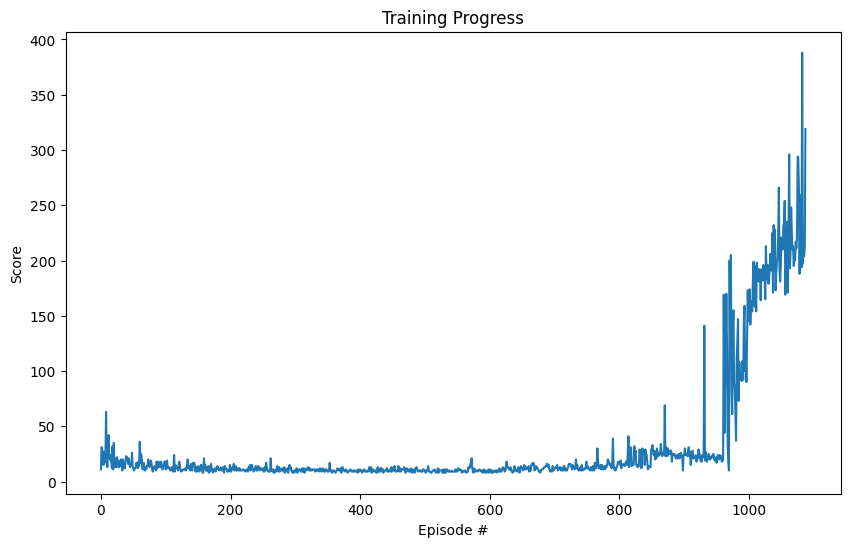

In [6]:
# Training function
def dqn(n_episodes=3000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    env = gym.make('CartPole-v1')
    agent = DQNAgent(state_size=4, action_size=2)
    scores = []                        # List containing scores from each episode
    scores_window = deque(maxlen=100)  # Last 100 scores
    eps = eps_start                    # Initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state, _ = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)            # Select an action
            next_state, reward, terminated, truncated, _ = env.step(action)  # Take action
            done = terminated or truncated
            agent.step(state, action, reward, next_state, done)  # Agent learns
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # Save most recent score
        scores.append(score)              # Save most recent score
        eps = max(eps_end, eps_decay*eps) # Decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=195.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            break
    env.close()
    # Plot the scores
    plt.figure(figsize=(10,6))
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.title('Training Progress')
    plt.show()
    return agent

# Train the agent
trained_agent = dqn()

---

### Animation of the Trained Agent

The following GIF shows the trained agent successfully balancing the pole after training in the **CartPole-v1** environment.

![CartPole Animation](./cartpole_animation.gif)


---